## **Well Being Prediction Analysis**

# Loading Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier


#Data Loading

In [3]:
#reading in CSV's from a file path
mental_df = pd.read_csv('mentalhealth1.csv')
print(mental_df.shape) #gives no of rows and coloumns
print(mental_df.describe()) #calculates various statistics for numerical column(age) in the DataFrame
print(mental_df.info()) #gives non null values for each column and its datatype

(22652, 27)
                Age
count  22652.000000
mean      30.924598
std       29.728673
min    -1726.000000
25%       26.000000
50%       32.000000
75%       36.000000
max      329.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22652 entries, 0 to 22651
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  22652 non-null  object
 1   Age                        22652 non-null  int64 
 2   Gender                     22652 non-null  object
 3   Country                    22652 non-null  object
 4   state                      12908 non-null  object
 5   self_employed              22274 non-null  object
 6   family_history             22652 non-null  object
 7   treatment                  22652 non-null  object
 8   work_interfere             18942 non-null  object
 9   no_employees               22652 non-null  object
 10  remote_work                22652 n

In [4]:
mental_df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Checking for number of null values in every coloum


In [5]:
print("Number of rows and columns",mental_df.shape)
total = mental_df.isnull().sum().sort_values(ascending=False)
print(total)


for col in mental_df.columns:
    mean_per = np.mean(mental_df[col].isnull())
    print('{} - {}%'.format(col,mean_per))
  



Number of rows and columns (22652, 27)
comments                     21511
state                         9744
work_interfere                3710
self_employed                  378
seek_help                        0
obs_consequence                  0
mental_vs_physical               0
phys_health_interview            0
mental_health_interview          0
supervisor                       0
coworkers                        0
phys_health_consequence          0
mental_health_consequence        0
leave                            0
anonymity                        0
Timestamp                        0
wellness_program                 0
Age                              0
benefits                         0
tech_company                     0
remote_work                      0
no_employees                     0
treatment                        0
family_history                   0
Country                          0
Gender                           0
care_options                     0
dtype: int64
Tim

Handling few missing values from above by dropping irrelevant coloumns

In [6]:
mental_df = mental_df.drop(['comments','state','Timestamp','Country'], axis= 1)
mental_df.head(5)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,NaN,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,NaN,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,NaN,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,NaN,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,NaN,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


We can also handle other missing values by assiging default values for each data type


In [7]:
# Setting default values for int and string data types
defaultInt = 0
defaultString = 'NaN'

# Create lists by data type
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']

# Fill mssing values with default values
for feature in mental_df:
    if feature in intFeatures:
        mental_df[feature] = mental_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        mental_df[feature] = mental_df[feature].fillna(defaultString)
    else:
        print('Error: Feature %s not recognized.' % feature)
mental_df.head(5)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,NaN,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,NaN,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,NaN,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,NaN,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,NaN,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


User input is inconsistant for Gender coloumn. In order to specify it into three main values Male, Female and Trans, We are categorizing the Gender coloumn

In [8]:

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in mental_df.iterrows():

    if str.lower(col.Gender) in male_str:
        mental_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        mental_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        mental_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

stk_list = ['A little about you', 'p']
mental_df = mental_df[~mental_df['Gender'].isin(stk_list)] # selecting only the rows where values are not in above list

print(mental_df['Gender'].unique())

['female' 'male' 'trans']


From the below box plot, we can see that there are outliers for age coloumn.


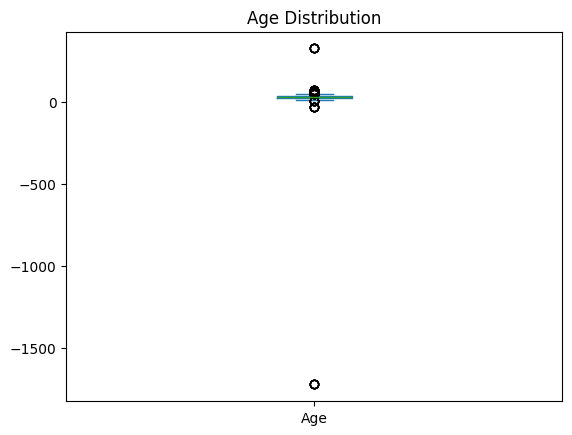

In [9]:
mental_df['Age'].plot.box()
plt.title('Age Distribution')
plt.show()

Replacing the outlier values for age with median

In [10]:

# Fill with median() values < 18 and > 65
s = pd.Series(mental_df['Age'])
s[s<18] = mental_df['Age'].median()
mental_df['Age'] = s
s = pd.Series(mental_df['Age'])
s[s>65] = mental_df['Age'].median()
mental_df['Age'] = s




The below box plot shows that the outliers are handled

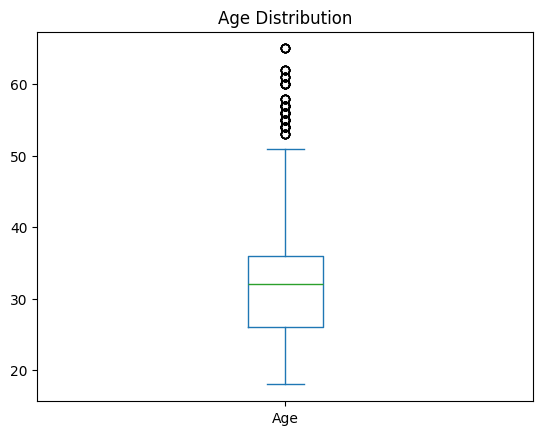

In [11]:
mental_df['Age'].plot.box()
plt.title('Age Distribution')
plt.show()

We are printing the statistics and information of the dataset to confirm the changes we made


In [12]:
print(mental_df.shape)
print(mental_df.describe())
print(mental_df.info())

(22624, 23)
                Age
count  22624.000000
mean      31.348479
std        6.326821
min       18.000000
25%       26.000000
50%       32.000000
75%       36.000000
max       65.000000
<class 'pandas.core.frame.DataFrame'>
Index: 22624 entries, 0 to 22651
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        22624 non-null  int64 
 1   Gender                     22624 non-null  object
 2   self_employed              22624 non-null  object
 3   family_history             22624 non-null  object
 4   treatment                  22624 non-null  object
 5   work_interfere             22624 non-null  object
 6   no_employees               22624 non-null  object
 7   remote_work                22624 non-null  object
 8   tech_company               22624 non-null  object
 9   benefits                   22624 non-null  object
 10  care_options               22624 non-nu

We have three values Yes, No and Nan for coloumn self_employed. Here we are replacing NAN value with NO as the percenatge of number of self_employed is very less.

In [13]:
mental_df['self_employed'] = mental_df['self_employed'].replace([defaultString], 'No')
print(mental_df['self_employed'].unique())

['No' 'Yes']


Similarly, We are replacing NAN values in coloumn work_interfer with "Don't Know" becuase the percentage of this category is very low.

In [14]:
mental_df['work_interfere'] = mental_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(mental_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [15]:
mental_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,female,No,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,male,No,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,male,No,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,male,No,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,male,No,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


##Data Visualization/Exploratory Data analysis

Stats of Employees with Health Benefits:

benefits
No            12320
Yes            7448
Don't know     2856
Name: count, dtype: int64


Text(0.5, 1.0, 'Benefits')

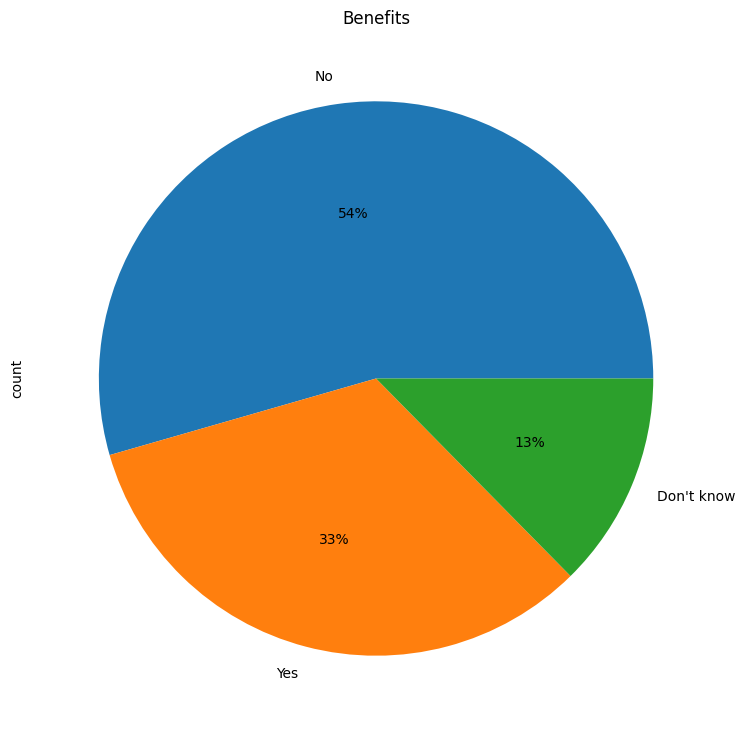

In [16]:
print(mental_df['benefits'].value_counts()) #total values for benefits with count

mental_df['benefits'].value_counts().plot.pie(figsize=(13,9), autopct='%1.0f%%').set_title("Benefits")

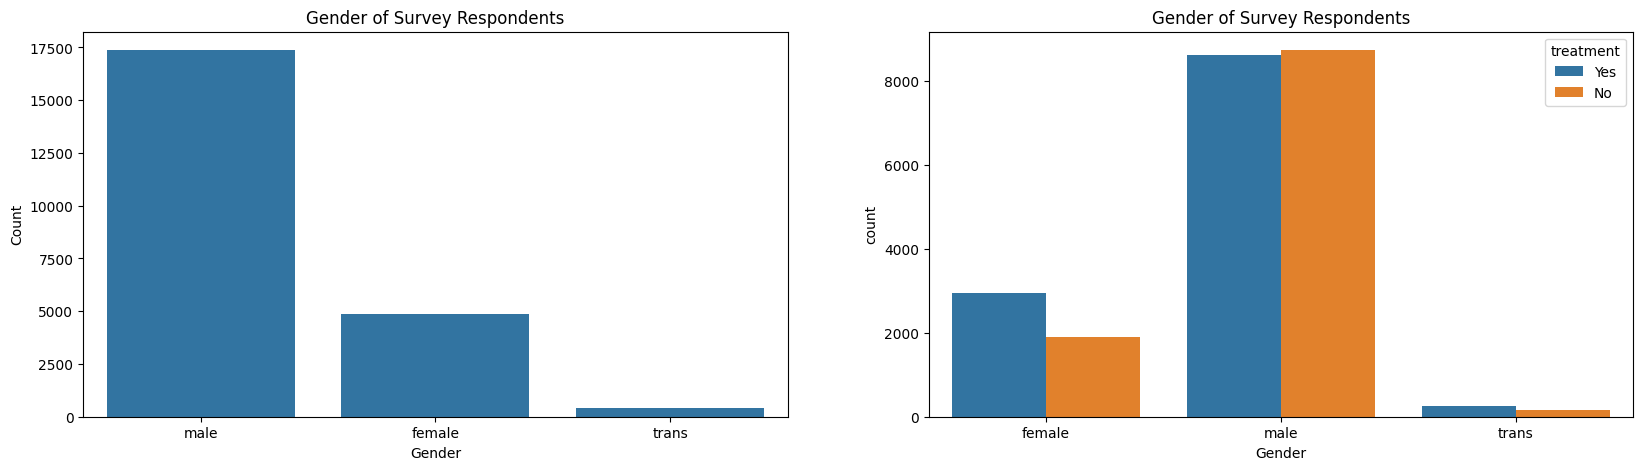

In [17]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1) #one row, two subplots, first subplot
eda_count = mental_df['Gender'].value_counts(normalize = False).rename_axis('Gender').reset_index(name = 'Count')
sns.barplot(x = 'Gender', y = 'Count', data = eda_count.head(10))
plt.title('Gender of Survey Respondents')
plt.subplot(1,2,2) #one row, two subplots, first subplot
sns.countplot(data=mental_df, x='Gender', hue='treatment')
plt.title('Gender of Survey Respondents')
plt.show()

Text(0.5, 0, 'Age')

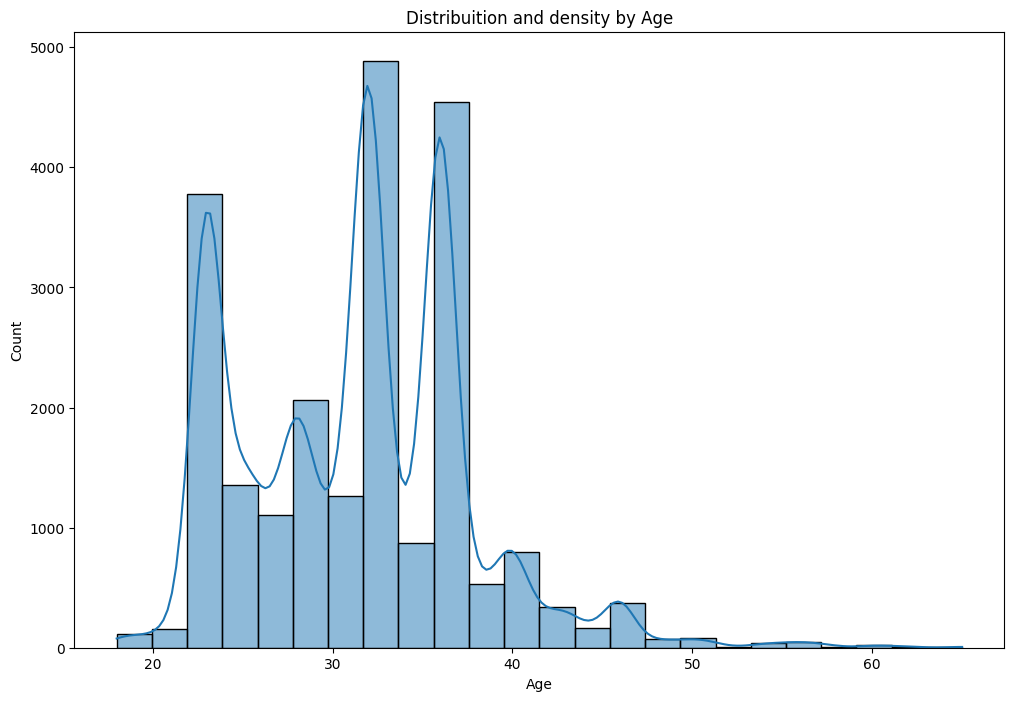

In [18]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.histplot(mental_df["Age"], bins=24, kde=True) #kde curve for continous data distribution
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

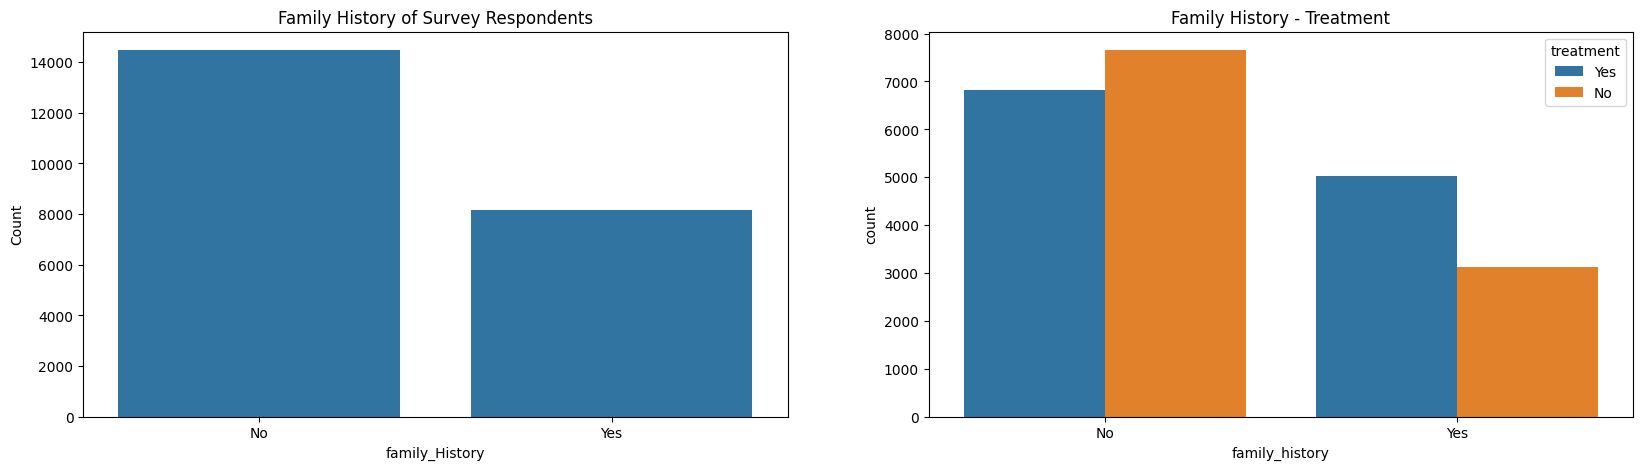

In [19]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
eda_count = mental_df['family_history'].value_counts(normalize = False).rename_axis('family_History').reset_index(name = 'Count')
sns.barplot(x = 'family_History', y = 'Count', data = eda_count)
plt.title('Family History of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(data = mental_df, x='family_history', hue = 'treatment') #The hue parameter
#is used to distinguish between categories within the 'work_interfere' column based on another variable, which is 'treatment' in this case
plt.title('Family History - Treatment')
plt.show()

C:\Users\rahul\AppData\Local\Temp\ipykernel_21404\2576308572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'work_interfere', y = 'Count', data = eda_count, palette='Dark2')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


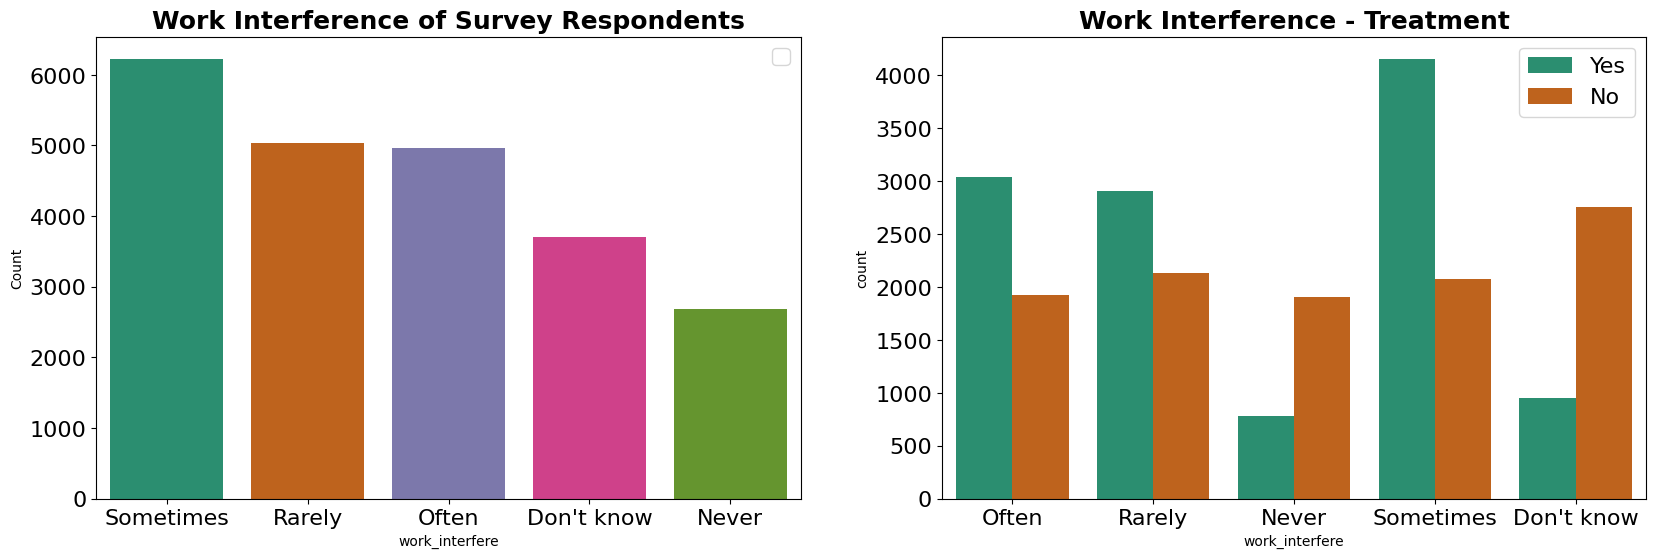

In [20]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_count = mental_df['work_interfere'].value_counts(normalize = False).rename_axis('work_interfere').reset_index(name = 'Count')
sns.barplot(x = 'work_interfere', y = 'Count', data = eda_count, palette='Dark2')

plt.title('Work Interference of Survey Respondents', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16) #font size on x axis
plt.yticks(fontsize=16) #font size on y axis
plt.legend(fontsize=16) #font size of legend

plt.subplot(1,2,2)
sns.countplot(data = mental_df, x = 'work_interfere', hue = 'treatment',  palette=dict(No = '#d95f02', Yes = '#1b9e77')) #The hue parameter
#is used to distinguish between categories within the 'work_interfere' column based on another variable, which is 'treatment' in this case
plt.title('Work Interference - Treatment', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

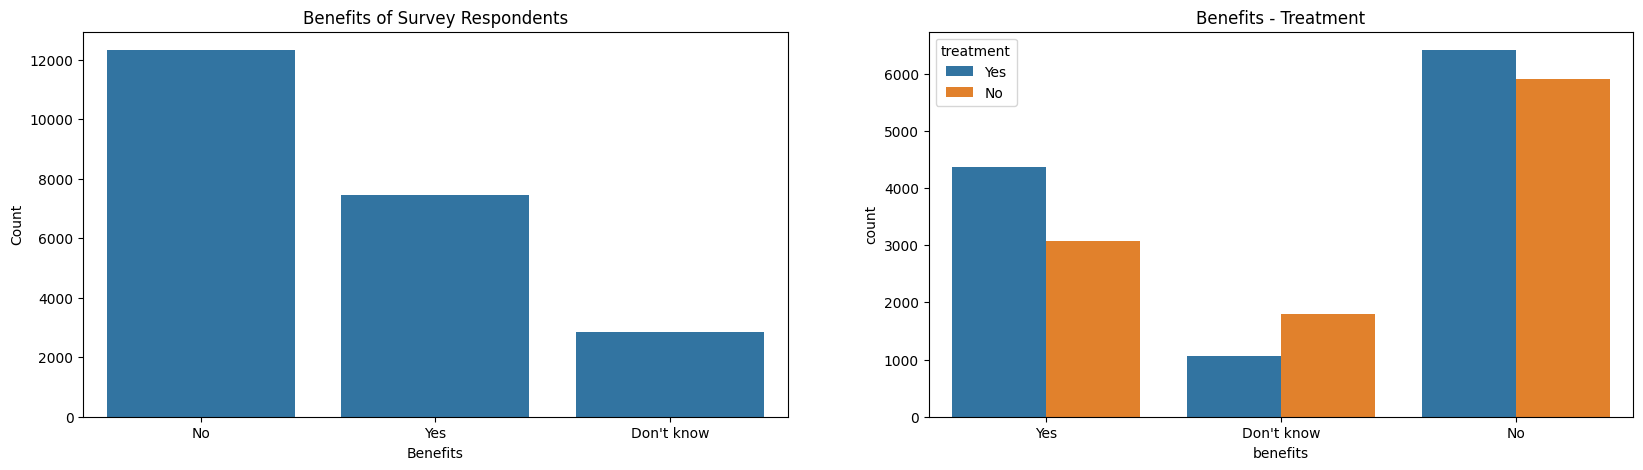

In [21]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
eda_count = mental_df['benefits'].value_counts(normalize = False).rename_axis('Benefits').reset_index(name = 'Count')
sns.barplot(x = 'Benefits', y = 'Count', data = eda_count)
plt.title('Benefits of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(data = mental_df, x = 'benefits', hue = 'treatment')
plt.title('Benefits - Treatment')
plt.show()

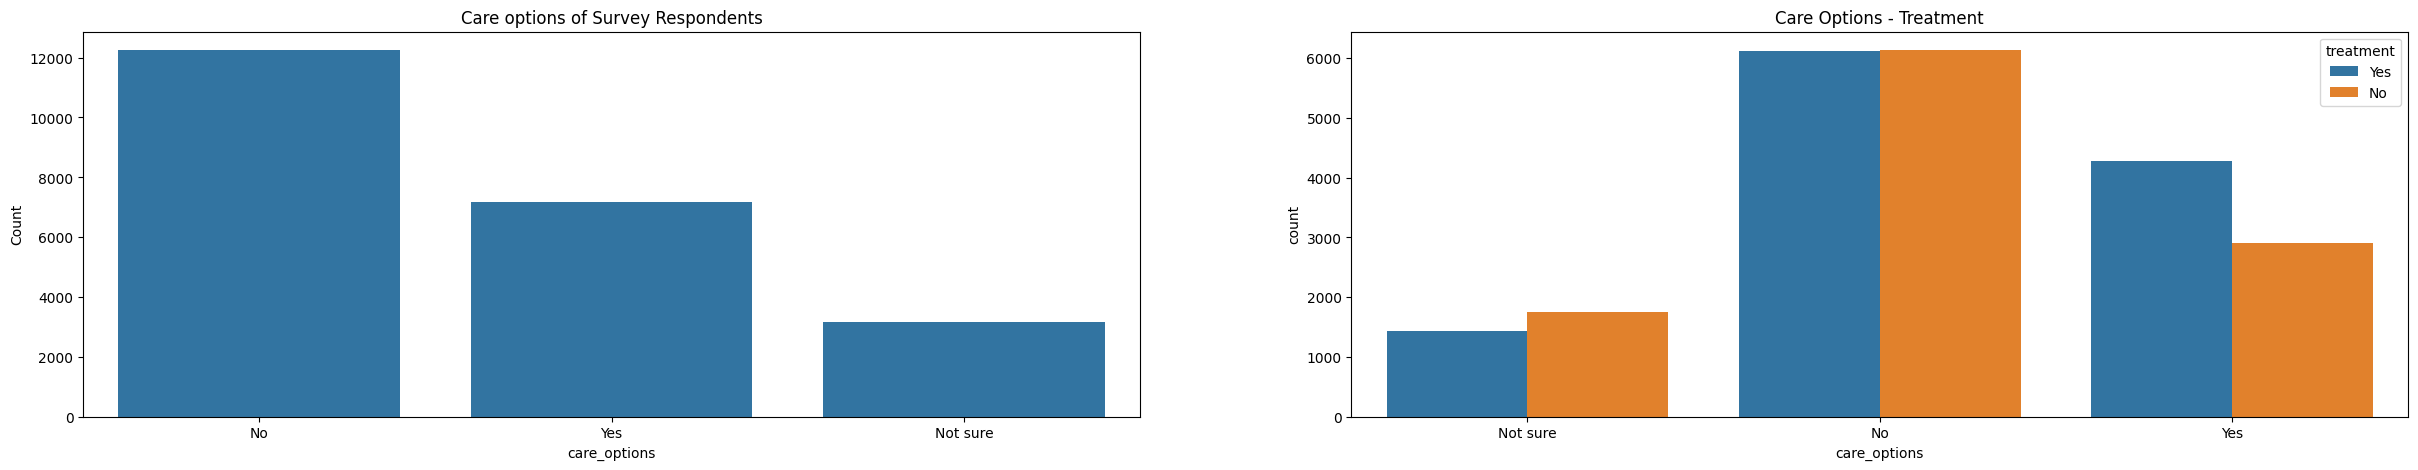

In [22]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
eda_count = mental_df['care_options'].value_counts(normalize = False).rename_axis('care_options').reset_index(name = 'Count')
sns.barplot(x = 'care_options', y = 'Count', data = eda_count)
plt.title('Care options of Survey Respondents')
plt.subplot(1,2,2)
sns.countplot(data = mental_df, x = 'care_options', hue = 'treatment')
plt.title('Care Options - Treatment')
plt.show()

**Encoding** :Encoding is used to transform the categorical values of the relevant features into numerical ones as the machine learning models can only work with the numerical ones.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler


In [24]:
labelDict = {} #empty dictionary to store info about categories in each coloumn
for feature in mental_df:  # for each coloumn
    le = preprocessing.LabelEncoder() #convert categorical (text-based) data into numerical data using preprocessing module
    le.fit(mental_df[feature]) #assign a unique numerical label to each unique value and map each category to a number.
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) #The zip function pairs the category names with their labels, and dict converts them into a dictionary.
    mental_df[feature] = le.transform(mental_df[feature]) #replacing the categorical values with their corresponding numerical labels.
    # Get labels
    print(le_name_mapping)


{18: 0, 19: 1, 20: 2, 21: 3, 22: 4, 23: 5, 24: 6, 25: 7, 26: 8, 27: 9, 28: 10, 29: 11, 30: 12, 31: 13, 32: 14, 33: 15, 34: 16, 35: 17, 36: 18, 37: 19, 38: 20, 39: 21, 40: 22, 41: 23, 42: 24, 43: 25, 44: 26, 45: 27, 46: 28, 47: 29, 48: 30, 49: 31, 50: 32, 51: 33, 53: 34, 54: 35, 55: 36, 56: 37, 57: 38, 58: 39, 60: 40, 61: 41, 62: 42, 65: 43}
{'female': 0, 'male': 1, 'trans': 2}
{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}
{"Don't know": 0, 'Never': 1, 'Often': 2, 'Rarely': 3, 'Sometimes': 4}
{'1-5': 0, '100-500': 1, '26-100': 2, '500-1000': 3, '6-25': 4, 'More than 1000': 5}
{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}
{"Don't know": 0, 'No': 1, 'Yes': 2}
{'No': 0, 'Not sure': 1, 'Yes': 2}
{"Don't know": 0, 'No': 1, 'Yes': 2}
{"Don't know": 0, 'No': 1, 'Yes': 2}
{"Don't know": 0, 'No': 1, 'Yes': 2}
{"Don't know": 0, 'Somewhat difficult': 1, 'Somewhat easy': 2, 'Very difficult': 3, 'Very easy': 4}
{'Maybe': 0, 'No': 1, 'Yes': 2}
{'Maybe': 0, 'No': 1, 'Yes': 2}
{'No': 0, 'Some o

In [25]:
mental_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,19,0,0,0,1,2,4,0,1,2,...,2,2,1,1,1,2,1,0,2,0
1,26,1,0,0,0,3,5,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,14,1,0,0,0,3,4,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,13,1,0,1,1,2,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,13,1,0,0,0,1,1,1,1,2,...,0,0,1,1,1,2,2,2,0,0


Text(0.5, 1.0, 'Total Distribuition by treated or not')

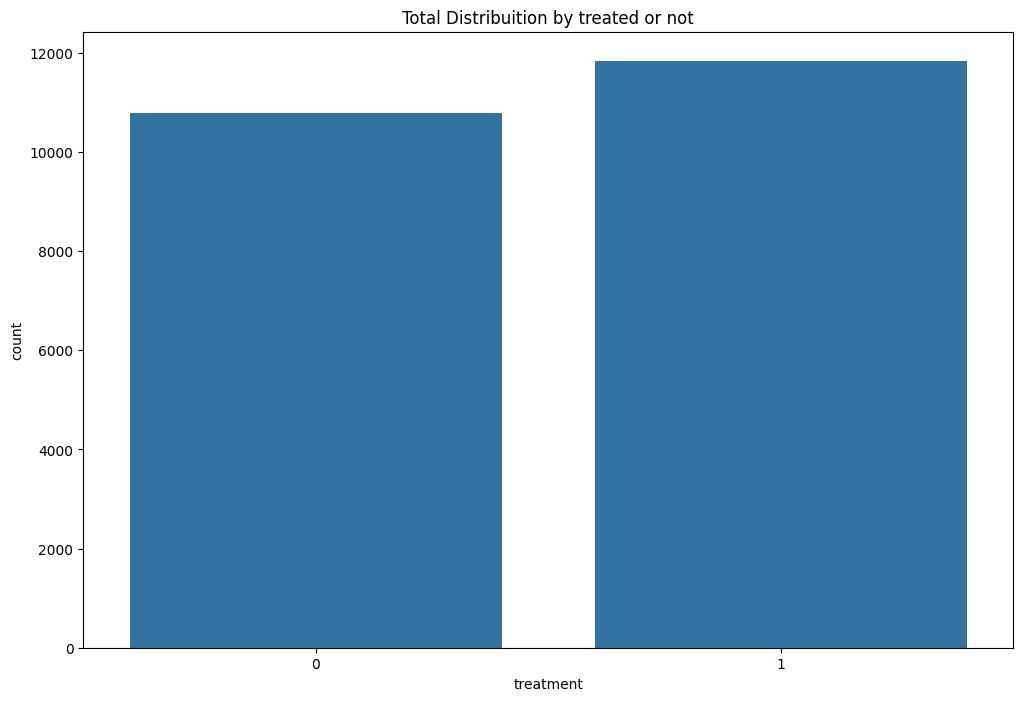

In [26]:
plt.figure(figsize=(12,8))
g = sns.countplot(x="treatment", data=mental_df)

plt.title('Total Distribuition by treated or not')

<Axes: >

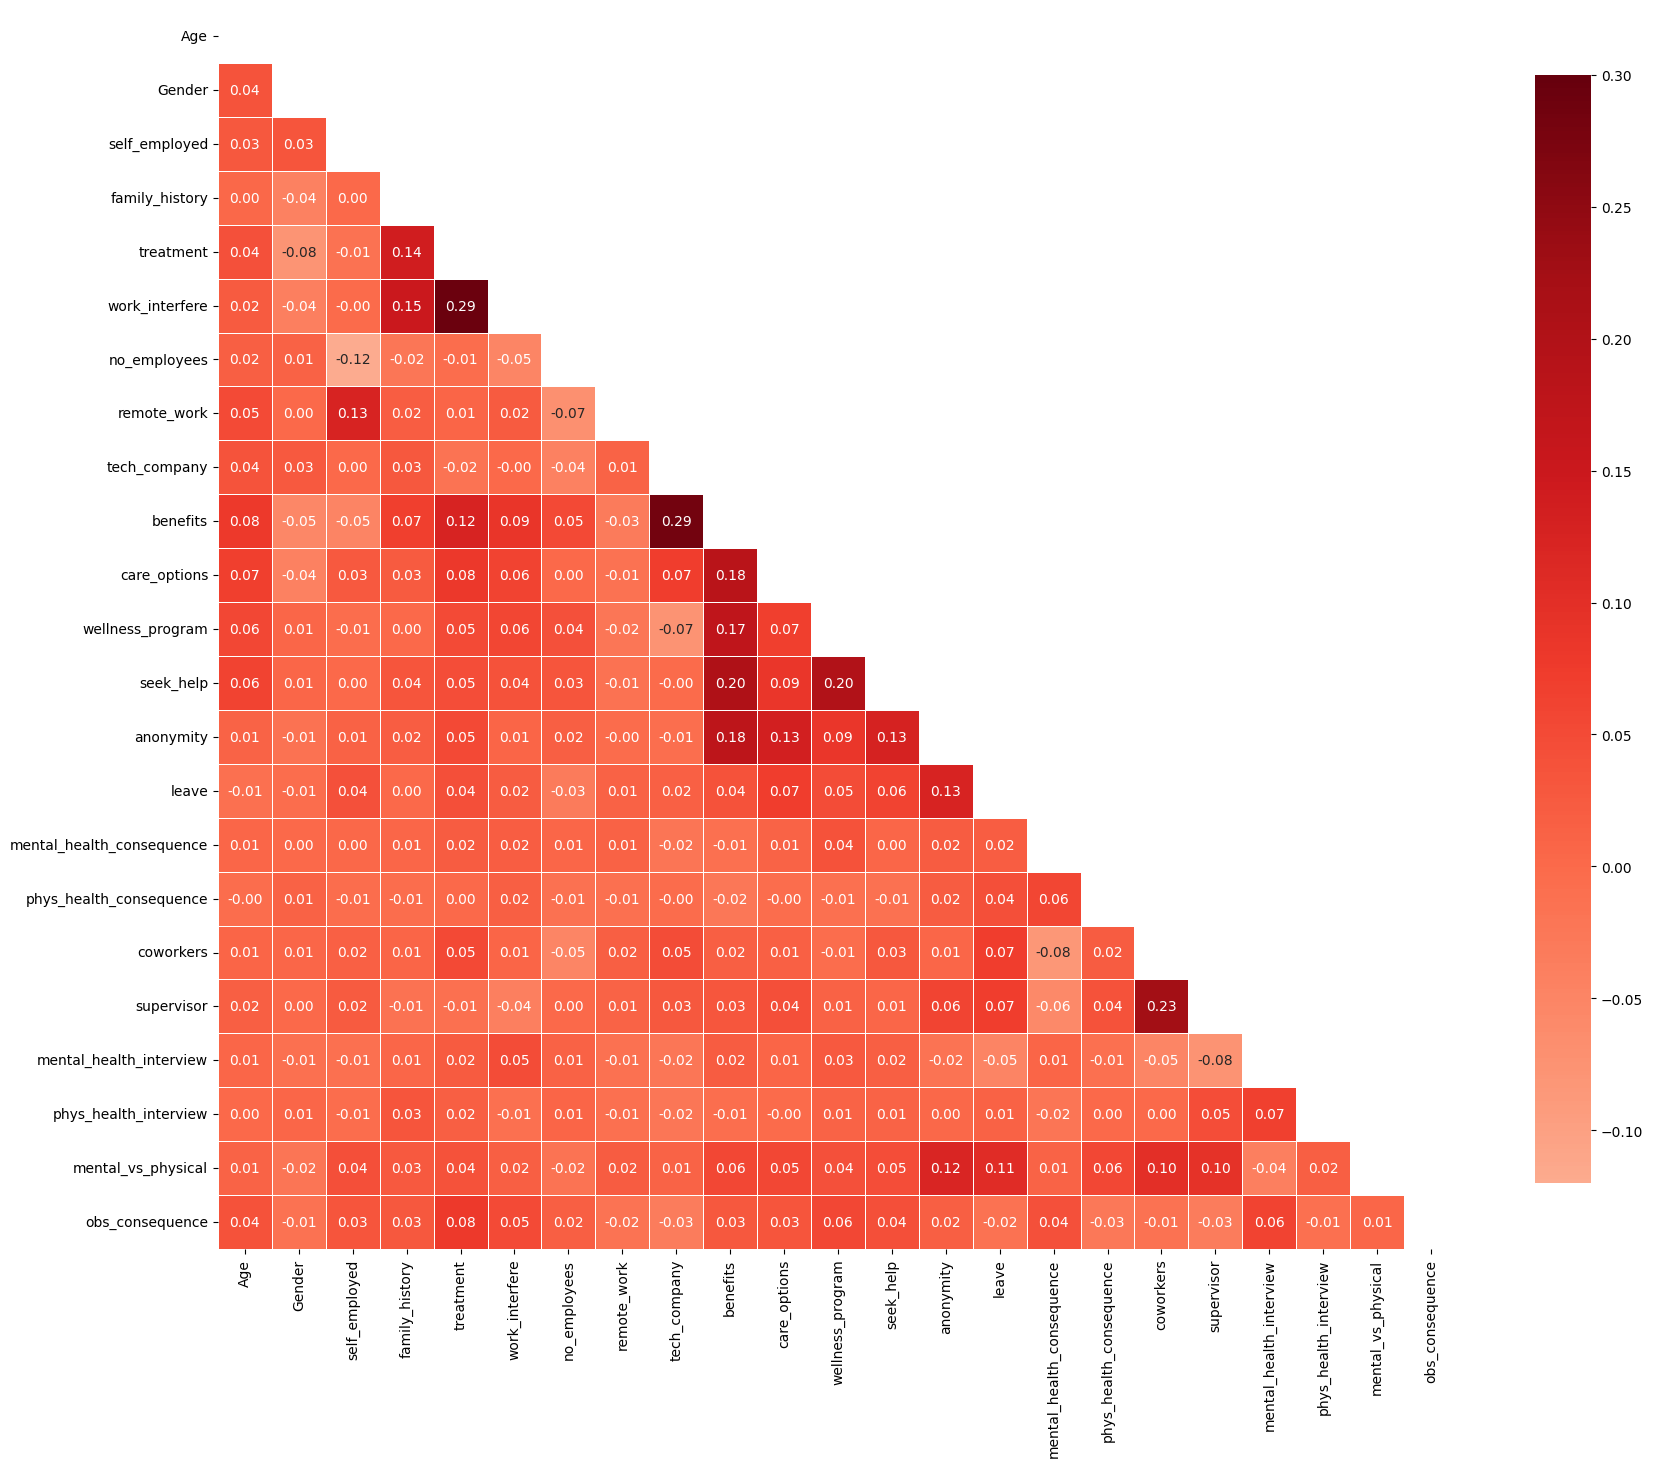

In [27]:
# Compute the correlation matrix
corr = mental_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool)) #mask for the upper triangle of the correlation matrix. upper triangle - True and lower triangle-False. To reduce redundancy


f, ax = plt.subplots(figsize=(20, 24))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6}, fmt='.2f',annot = True)

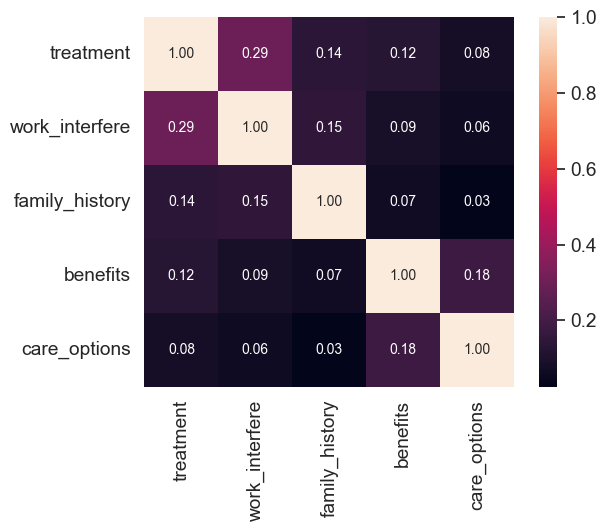

In [28]:
#treatment correlation matrix
k = 5 #number of variables for heatmap
cols = corr.nlargest(k, 'treatment')['treatment'].index #calculates 5 largest correlations with treatment
cm = np.corrcoef(mental_df[cols].values.T) # new correlation matrix for treatment and 5 coloumns
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,  fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Scaling age coloumn to normalize the data and avoid its over influence on other coloumns

In [29]:
scaler = MinMaxScaler() #scales features to a range between 0 and 1
mental_df['Age'] = scaler.fit_transform(mental_df[['Age']])
mental_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0.441860,0,0,0,1,2,4,0,1,2,...,2,2,1,1,1,2,1,0,2,0
1,0.604651,1,0,0,0,3,5,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,0.325581,1,0,0,0,3,4,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,0.302326,1,0,1,1,2,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,0.302326,1,0,0,0,1,1,1,1,2,...,0,0,1,1,1,2,2,2,0,0


Data Partitioning

In [30]:

feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']

X = mental_df[feature_cols] #input
y = mental_df.treatment #target

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#Data Modelling

**Logistic Regression**

In [31]:
from sklearn.linear_model import LogisticRegression
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0) # 'liblinear' - small to medium-sized datasets and for binary classification problems.
# fit the model
logreg.fit(X_train, y_train) #fitting the model aon training data

LogisticRegression(random_state=0, solver='liblinear')

In [32]:
y_pred_class = logreg.predict(X_test) #making predictions on test data
log=metrics.accuracy_score(y_test, y_pred_class) #calculating accuracy
print('Logistic Regression Model-Accuracy:', log)

Logistic Regression Model-Accuracy: 0.6475138121546962


Logistic:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      2167
           1       0.65      0.72      0.68      2358

    accuracy                           0.65      4525
   macro avg       0.65      0.64      0.64      4525
weighted avg       0.65      0.65      0.65      4525

confusion matrix 


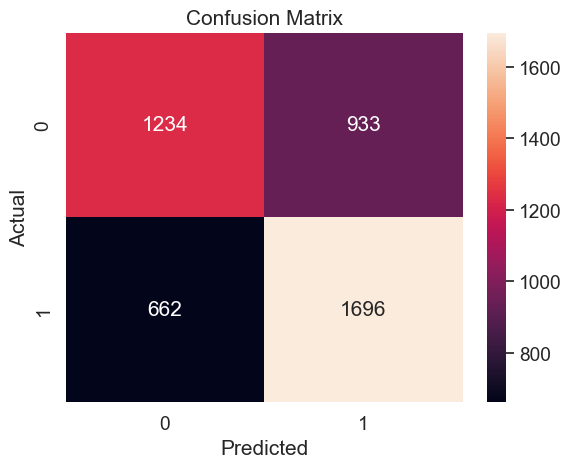

In [33]:
y_pred_log = logreg.predict(X_test)

print("Logistic:")
print(classification_report(y_test, y_pred_log)) #prints metrics

confusion = metrics.confusion_matrix(y_test, y_pred_class)#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("confusion matrix ")
sns.heatmap(confusion,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [34]:
from joblib import dump,load

dump(logreg , 'model.joblib')


['model.joblib']

In [43]:


data = [0.441860, 0, 0, 0, 1, 2, 4, 0]

# Reshape the data into an 8-column DataFrame
dftest = np.array(data).reshape(1, -1)

dftest = pd.DataFrame(dftest, columns=['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere'])


In [44]:
model_in = load('model.joblib')

model_in.predict(dftest)


array([0])

In [ ]:
import joblib
import pickle

# Load the joblib file
loaded_model = joblib.load("model.joblib")

# Create a pickle file
with open("my_model.pkl", "wb") as pkl_file:
    pickle.dump(loaded_model, pkl_file)


**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# train a decision tree model on the training set
tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=6,
                       min_samples_leaf=7, min_samples_split=8)

In [ ]:
y_pred_class = tree.predict(X_test)
treeac=metrics.accuracy_score(y_test, y_pred_class)

print('Decision Tree Model-Accuracy:', treeac)

Decision Tree Model-Accuracy: 0.6545856353591161


Decision Trees:
              precision    recall  f1-score   support

           0       0.74      0.43      0.55      2167
           1       0.62      0.86      0.72      2358

    accuracy                           0.65      4525
   macro avg       0.68      0.65      0.63      4525
weighted avg       0.68      0.65      0.64      4525

confusion matrix 


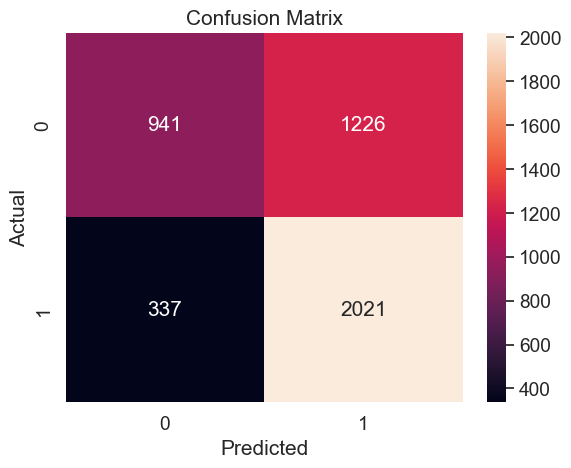

In [ ]:
y_pred_tree = tree.predict(X_test)

print("Decision Trees:")
print(classification_report(y_test, y_pred_tree))

confusion = metrics.confusion_matrix(y_test, y_pred_class)#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("confusion matrix ")
sns.heatmap(confusion,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Random Forest**

In [ ]:
forest = RandomForestClassifier(n_estimators = 20)

featuresSize = feature_cols.__len__()

# Building and fitting my_forest
forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
my_forest = forest.fit(X_train, y_train)

In [ ]:
y_pred_class = my_forest.predict(X_test)
randac=metrics.accuracy_score(y_test, y_pred_class)
print('Random Forest Model-Accuracy:',randac )

Random Forest Model-Accuracy: 0.8026519337016574


Random forest:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2167
           1       0.79      0.84      0.82      2358

    accuracy                           0.80      4525
   macro avg       0.80      0.80      0.80      4525
weighted avg       0.80      0.80      0.80      4525

confusion matrix 


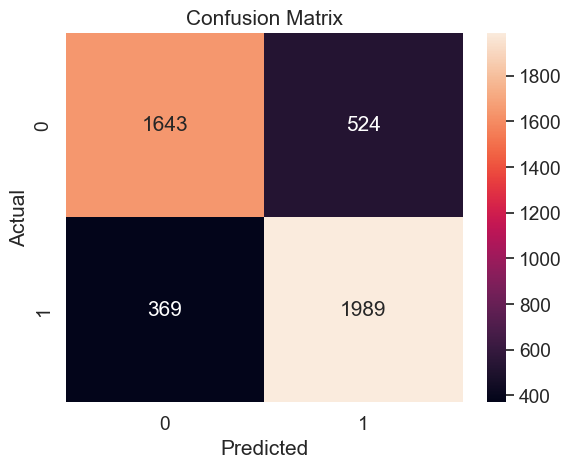

In [ ]:
y_pred_forest = forest.predict(X_test)

print("Random forest:")
print(classification_report(y_test, y_pred_forest))

confusion = metrics.confusion_matrix(y_test, y_pred_class)#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("confusion matrix ")
sns.heatmap(confusion,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**KNeighbors Classifier**





In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
y_pred_class = knn.predict(X_test)
knnac=metrics.accuracy_score(y_test, y_pred_class)
print('K Neighbor Model-Accuracy:',knnac )

K Neighbor Model-Accuracy: 0.8766850828729281


KNN:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2167
           1       0.88      0.89      0.88      2358

    accuracy                           0.88      4525
   macro avg       0.88      0.88      0.88      4525
weighted avg       0.88      0.88      0.88      4525

confusion matrix 


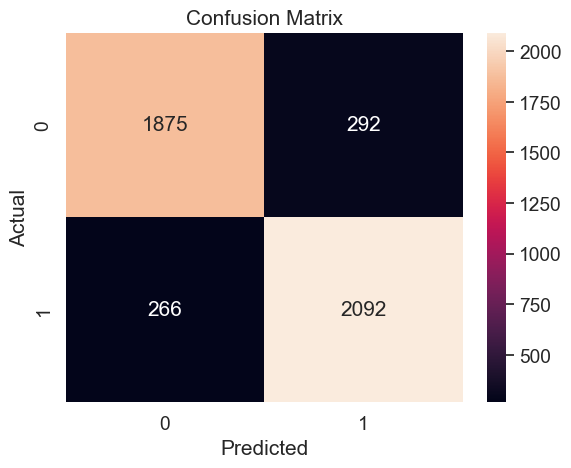

In [ ]:
y_pred_knn = knn.predict(X_test)

print("KNN:")
print(classification_report(y_test, y_pred_knn))

confusion = metrics.confusion_matrix(y_test, y_pred_class)#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("confusion matrix ")
sns.heatmap(confusion,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Comparision of Models

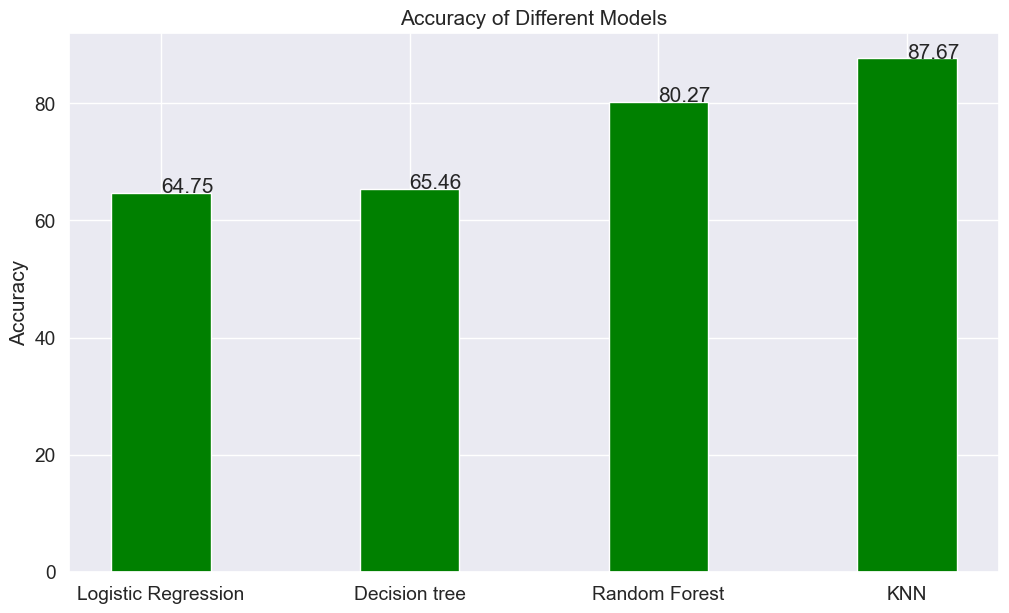

In [ ]:

data = {'Logistic Regression':log*100, 'Decision tree':treeac*100, 'Random Forest':randac*100,
		'KNN':knnac*100} #dictionary of model accuracies
models = list(data.keys()) #extract model names and accuracies
accuracies = list(data.values())
accuracies.sort()

fig = plt.figure(figsize = (12, 7))

for i in range(len(models)):
        plt.text(i,round(accuracies[i],2),round(accuracies[i],2)) #adding text labels to the bars

# creating the bar plot
plt.bar(models, accuracies, color ='green',width = 0.4,)


plt.ylabel("Accuracy")

plt.title("Accuracy of Different Models")
plt.show()
